# QRT ENS Data Challenge 2023 - Benchmark 

## Libraries

If not installed, install XGBoost by uncommenting and executing this cell

In [3]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import os

## Loading data

- `X_train` and `X_test` both have $35$ columns that represent the same explanatory variables but over different time periods. 

- `X_train` and `Y_train` share the same column `ID` - each row corresponds to a unique ID associated wwith a day and a country. 

- The target of this challenge `TARGET` in `Y_train` corresponds to the price change for daily futures contracts of 24H electricity baseload. 

- **You will notice some columns have missing values**.


In [4]:
%cd

C:\Users\hugot


In [5]:
main_path = 'Documents\Code\EL_project'

In [6]:
# After downloading the X_train/X_test/Y_train .csv files in your working directory:
X_train_path = os.path.join(main_path, 'datasets\X_train.csv')
X_train = pd.read_csv(X_train_path)

Y_train_path = os.path.join(main_path, 'datasets\y_train.csv')
Y_train = pd.read_csv(Y_train_path)

X_test_path = os.path.join(main_path, 'datasets\X_test.csv')
X_test = pd.read_csv(X_test_path)

In [7]:
X_train.head()

,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
0,1054,206,FR,0.210099,-0.427458,-0.606523,0.606523,NaN,0.692860,NaN,...,-0.444661,-0.172680,-0.556356,-0.790823,-0.283160,-1.069070,-0.063404,0.339041,0.124552,-0.002445
1,2049,501,FR,-0.022399,-1.003452,-0.022063,0.022063,-0.573520,-1.130838,0.573520,...,-1.183194,-1.240300,-0.770457,1.522331,0.828412,0.437419,1.831241,-0.659091,0.047114,-0.490365
2,1924,687,FR,1.395035,1.978665,1.021305,-1.021305,-0.622021,-1.682587,0.622021,...,1.947273,-0.480700,-0.313338,0.431134,0.487608,0.684884,0.114836,0.535974,0.743338,0.204952
3,297,720,DE,-0.983324,-0.849198,-0.839586,0.839586,-0.270870,0.563230,0.270870,...,-0.976974,-1.114838,-0.507570,-0.499409,-0.236249,0.350938,-0.417514,0.911652,-0.296168,1.073948
4,1101,818,FR,0.143807,-0.617038,-0.924990,0.924990,NaN,0.990324,NaN,...,-0.526267,-0.541465,-0.424550,-1.088158,-1.011560,0.614338,0.729495,0.245109,1.526606,2.614378


In [8]:
Y_train.head()

,ID,TARGET
0,1054,0.028313
1,2049,-0.112516
2,1924,-0.180840
3,297,-0.260356
4,1101,-0.071733


## Let's do some preprocessing

In [9]:
X_train.columns

Index(['ID', 'DAY_ID', 'COUNTRY', 'DE_CONSUMPTION', 'FR_CONSUMPTION',
       'DE_FR_EXCHANGE', 'FR_DE_EXCHANGE', 'DE_NET_EXPORT', 'FR_NET_EXPORT',
       'DE_NET_IMPORT', 'FR_NET_IMPORT', 'DE_GAS', 'FR_GAS', 'DE_COAL',
       'FR_COAL', 'DE_HYDRO', 'FR_HYDRO', 'DE_NUCLEAR', 'FR_NUCLEAR',
       'DE_SOLAR', 'FR_SOLAR', 'DE_WINDPOW', 'FR_WINDPOW', 'DE_LIGNITE',
       'DE_RESIDUAL_LOAD', 'FR_RESIDUAL_LOAD', 'DE_RAIN', 'FR_RAIN', 'DE_WIND',
       'FR_WIND', 'DE_TEMP', 'FR_TEMP', 'GAS_RET', 'COAL_RET', 'CARBON_RET'],
      dtype='object')

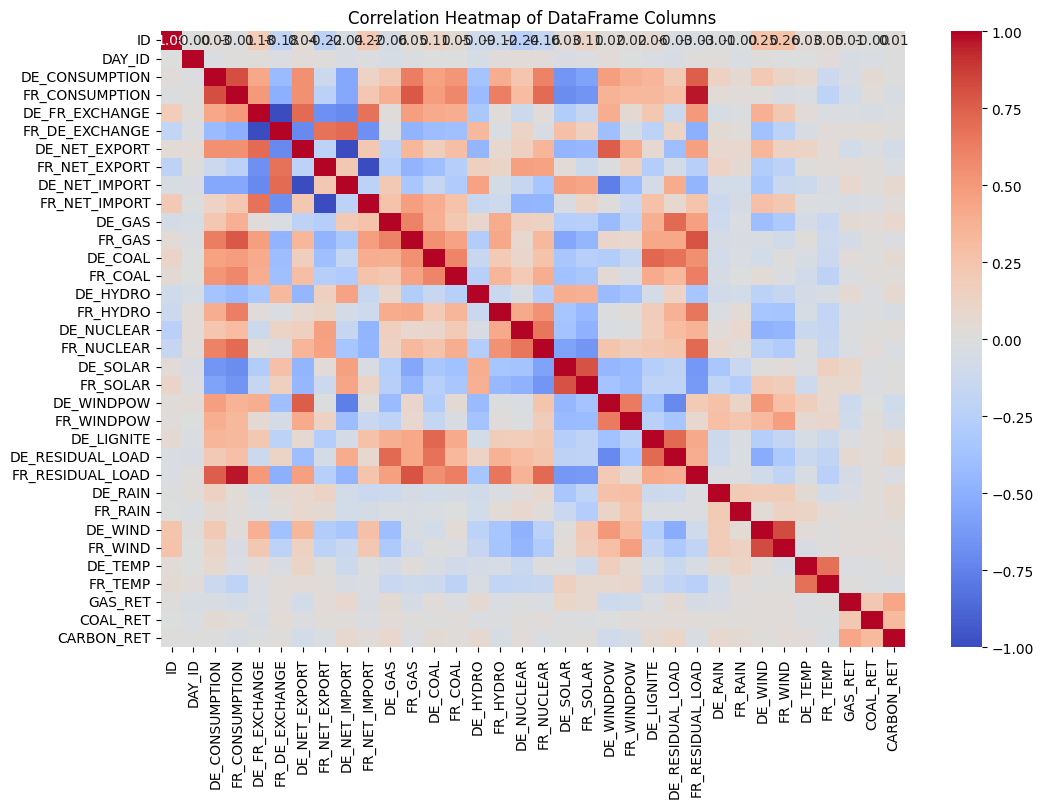

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
correlation_matrix = X_train.drop("COUNTRY", axis = 1).corr()

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of DataFrame Columns')
plt.show()


Obviously some columns are redundant.
Let's find which automatically to get rid of them

In [11]:
threshold = 0.95

high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

for pair in high_corr_pairs:
    print("High correlation between:", pair[0], "and", pair[1], ":", pair[2])


High correlation between: FR_CONSUMPTION and FR_RESIDUAL_LOAD : 0.9650862507900667
High correlation between: DE_FR_EXCHANGE and FR_DE_EXCHANGE : -1.0
High correlation between: DE_NET_EXPORT and DE_NET_IMPORT : -1.0
High correlation between: FR_NET_EXPORT and FR_NET_IMPORT : -1.0


These columns may not add any information to the model. We'll drop them.

Country column is a string. Let's encode it. there are only two countries : France and Germany so we chan assign 1 to the first one and -1 to the other one:

In [12]:
X_train['COUNTRY'].value_counts()

COUNTRY
FR    851
DE    643
Name: count, dtype: int64

In [13]:
X_train["BINARY_COUNTRY"] = X_train["COUNTRY"].apply(lambda x: 1 if x == "DE" else -1)   
X_test["BINARY_COUNTRY"] = X_test["COUNTRY"].apply(lambda x: 1 if x == "DE" else -1)  

Let's drop the columns we wanted to drop and created clean datasets to be used.

In [14]:
#I also dropped the "ID" and "DAY_ID" columns, as they are not relevant for the prediction ??

X_train_clean = X_train.drop(["ID", "DAY_ID", "COUNTRY", "FR_RESIDUAL_LOAD", "DE_FR_EXCHANGE", "DE_NET_EXPORT", "FR_NET_EXPORT"], axis = 1)
X_test_clean = X_test.drop(["ID", "DAY_ID",  "COUNTRY", "FR_RESIDUAL_LOAD", "DE_FR_EXCHANGE", "DE_NET_EXPORT", "FR_NET_EXPORT"], axis = 1)

Y_train_clean = Y_train.drop("ID", axis = 1)

There are some NAN values. Let's put the median instead

In [15]:
X_train_clean.isnull().sum().sum()

783

In [16]:
X_train_clean = X_train_clean.fillna(X_train_clean.median())

Let's see the correlation between the features selected and the target

In [17]:
concatenated_df = pd.concat([X_train_clean, Y_train_clean], axis=1)
correlation_with_target = concatenated_df.corr()['TARGET'].drop("TARGET", axis = 0)

print(correlation_with_target)

DE_CONSUMPTION     -0.052565
FR_CONSUMPTION     -0.005685
FR_DE_EXCHANGE      0.020137
DE_NET_IMPORT       0.151824
FR_NET_IMPORT       0.024398
DE_GAS              0.096657
FR_GAS              0.024652
DE_COAL             0.045181
FR_COAL             0.015732
DE_HYDRO            0.086127
FR_HYDRO            0.052820
DE_NUCLEAR          0.012236
FR_NUCLEAR          0.001588
DE_SOLAR            0.021934
FR_SOLAR            0.021081
DE_WINDPOW         -0.150287
FR_WINDPOW         -0.132523
DE_LIGNITE          0.034433
DE_RESIDUAL_LOAD    0.132555
DE_RAIN            -0.038336
FR_RAIN            -0.039055
DE_WIND            -0.080509
FR_WIND            -0.047700
DE_TEMP            -0.042897
FR_TEMP            -0.045186
GAS_RET             0.041969
COAL_RET           -0.010285
CARBON_RET          0.038252
BINARY_COUNTRY      0.048840
Name: TARGET, dtype: float64


Let's try some models on this clean datasets. We can do a benchmark to test them all and compare their performance. We'll also make some analysis to understand with which criteria they predict 

## UTILS FUNCTIONS

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(model, X_test, y_test):
    """
    Evaluate a regression model and return MSE, MAE, and R-squared.
    
    Parameters:
    - model: A trained regression model from Scikit-learn.
    - X_test: Test features.
    - y_test: True target values.

    Returns:
    - mse: Mean Squared Error.
    - mae: Mean Absolute Error.
    - r2: R-squared.
    """
    # Predict on test set
    y_pred = model.predict(X_test)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return mse, mae, r2

def plot_predictions(model, X_test, Y_test):
    """
    Plot the predictions of a regression model.
    
    Parameters:
    - y_test: True target values.
    - y_pred: Predicted target values.
    """
    # Predict on test set
    y_pred = model.predict(X_test)

    plt.figure(figsize=(10, 6))

    # Plot true values
    plt.scatter(Y_test, Y_test, color = "b", label = "True values")

    # Plot predicted values
    plt.scatter(Y_test, y_pred, color = "r", label = "Predicted values")

    plt.title('True vs Predicted Values')
    plt.xlabel('True values')
    plt.ylabel('Predicted values')
    plt.legend()
    plt.show()

## MODELS

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

#I'm not able to run XGBoost so I commented it
#from xgboost import XGBRegressor

def get_model(model_wanted: str, X_train, Y_train, parameters = None) -> object:

    if model_wanted == "linear_regression": #provided in by ENS
        lr = LinearRegression()
        lr.fit(X_train, Y_train)
        return lr
    
    elif model_wanted == "random_forest": #2nd lecture
        rf = RandomForestRegressor(**parameters)
        rf.fit(X_train, Y_train)
        return rf
    
    elif model_wanted == "gradient_boosting": #parameters to tune
        gb = GradientBoostingRegressor(**parameters)
        gb.fit(X_train, Y_train)
        return gb
    
    # elif model_wanted == "xgboost": #parameters to tune
    #     xgb = XGBRegressor(**parameters)
    #     xgb.fit(X_train, Y_train)
    #     return xgb
    
    else:
        raise ValueError("Invalid model name")


## BENCHMARKING

In [26]:
#Defining the model to test. Template : {"model_name" : {"parameter1" : value1, "parameter2" : value2, ...}}
#If the model has no parameters to tune, the value is None
models_to_test = {"linear_regression" : None, 
                  "random_forest" : {"n_estimators" : 100, "random_state" :777}, 
                  "gradient_boosting" : {"n_estimators" :100, "random_state" :777}, 
                  #"xgboost" : {"n_estimators" :100, "random_state" :777}
                  }


In [30]:
import time

results = []
for model_wanted, params in models_to_test.items():
    start_time = time.time()
    model = get_model(model_wanted, X_train_clean, Y_train_clean, params)
    training_time = time.time() - start_time
    
    mse, mae, r2 = evaluate_model(model, X_train_clean, Y_train_clean)
    results.append({"Model": model_wanted, "MSE": mse, "MAE": mae, "R-squared": r2, "Training Time (s)": training_time})

results_df = pd.DataFrame(results)


C:\Users\hugot\AppData\Local\Temp\ipykernel_11880\3011427008.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, Y_train)
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [31]:
results_df

,Model,MSE,MAE,R-squared,Training Time (s)
0,linear_regression,1.007117,0.571039,0.058456,0.006641
1,random_forest,0.171340,0.243104,0.839816,4.783529
2,gradient_boosting,0.579929,0.462395,0.457830,1.102091


Some ideas :
- feature selection
- Grid Search CV to tune the parameters
- Implement some other models...
- Then focus on the explainability of the models : variable importance, vizualisations...